## Load datasets

load the two CSV files:
- `original_preprocess.csv` (ORAN dataset)
- `dataset_ul.csv` (UL dataset)

also print their shapes to understand the dataset size.

In [306]:
import pandas as pd

oran = pd.read_csv("origin_data/original_preprocess.csv")
ul = pd.read_csv("origin_data/dataset_ul.csv")

In [307]:
print("ORAN raw shape:", oran.shape)
print("UL raw shape  :", ul.shape)

ORAN raw shape: (17501, 39)
UL raw shape  : (20018, 40)


In [308]:
oran.head()
oran.shape
oran.columns

Index(['date', 'BW', 'TM', 'traffic_load_dl', 'traffic_load_ul', 'txgain_dl',
       'txgain_ul', 'selected_mcs_dl', 'selected_mcs_ul',
       'selected_airtime_dl', 'selected_airtime_ul', 'mean_used_mcs_dl',
       'mean_used_mcs_ul', 'bsr_dl', 'bsr_ul', 'gput_ul', 'mean_snr_ul',
       'turbodec_it', 'dec_time', 'nRBs_ul', 'num_ues', 'thr_dl', 'thr_ul',
       'bler_dl', 'bler_ul', 'tbs_dl', 'pm_power', 'pm_var', 'pm_median',
       'n_pm', 'rapl_power', 'rapl_var', 'n_rapl', 'clockspeed', 'airtime_dl',
       'airtime_ul', 'cqi_dl', 'cqi_ul', 'fixed_mcs_flag'],
      dtype='object')

In [309]:
oran.isna().sum()
oran = oran.dropna()
oran = oran[oran["pm_power"] > 0]

In [310]:
ul.shape
ul.columns

Index(['date', 'cpu_platform', 'BW', 'TM', 'UL/DL', 'traffic_load', 'txgain',
       'cpu_time', 'number_active_cores', 'pinning', 'cpu_config',
       'selected_mcs', 'selected_airtime', 'mean_used_mcs', 'bsr', 'num_ues',
       'thr', 'gput', 'mean_snr', 'var_snr', 'bler', 'turbodec_it',
       'rssi_mean', 'rssi_var', 'overflows', 'underflows', 'lates', 'dec_time',
       'pm_power', 'pm_var', 'n_pm', 'rapl_power', 'rapl_var', 'n_rapl',
       'clockspeed', 'nRBs', 'airtime', 'num_subsamples', 'fixed_mcs_flag',
       'failed_experiment'],
      dtype='object')

In [311]:
ul.isna().sum()
ul = ul.dropna()
ul = ul[ul["rapl_power"] > 0]

## Define target and common features

To enable fair comparison and transfer learning, choosing a small set of robust common features that exist in both datasets, which can be mapped easily.

Target variable:
- predict **pm_power** (power meter measurement).  

Selected common features (input X):
- selected_airtime
- selected_mcs
- txgain


This results in a compact aligned dataset with 5 input features and 1 target column.


In [312]:
TARGET = "pm_power"

COMMON_FEATURES = [
    "airtime",
    "selected_mcs",
    "txgain"

]


## ORAN preprocessing and alignment

The ORAN dataset contains separate UL/DL columns (e.g., `airtime_ul`, `traffic_load_ul`).
Since this project focuses on uplink behaviour, extract the UL-related columns and rename them into a shared naming scheme.

Steps:
1) Select the relevant UL columns and the target column.
2) Rename the UL columns (e.g., `airtime_ul` → `airtime`) to match the UL dataset.
3) Convert all selected columns to numeric format.
4) Remove rows with missing values and invalid target values (power ≤ 0).

The output is a cleaned ORAN table with the same column names as the UL table.


In [313]:

oran_colmap = {
    "airtime_ul": "airtime",
    "selected_mcs_ul": "selected_mcs",
    "txgain_ul":"txgain",

    TARGET: TARGET  
}

oran_needed_cols = list(oran_colmap.keys())


oran = oran[oran_needed_cols].copy()
oran = oran.rename(columns=oran_colmap)

for c in COMMON_FEATURES + [TARGET]:
    oran[c] = pd.to_numeric(oran[c], errors="coerce")

oran = oran.dropna(subset=COMMON_FEATURES + [TARGET])
oran = oran[oran[TARGET] > 0]

print("✅ ORAN cleaned shape:", oran.shape)

✅ ORAN cleaned shape: (17501, 4)


## UL preprocessing

The UL dataset only contains ULrecords, and may include failed experiments.

Steps:
1) Filter to keep **UL** records only (`UL/DL == "UL"`).
2) Remove failed experiments (`failed_experiment == 0`).
3) Keep only the selected common features and the target column.
4) Convert selected columns to numeric format.
5) Remove missing values and invalid target values (power ≤ 0).

The output is a cleaned UL table with the same columns as the ORAN table.


In [314]:

# 1) Only retain UL (if there is a UL/DL column)
if "UL/DL" in ul.columns:
    ul = ul[ul["UL/DL"] == "UL"].copy()

# 2) Only filter the conditions
ul_raw = ul.copy()

ul_cond = ul_raw[
    (ul_raw["BW"] == 50) &
    (ul_raw["traffic_load"] == 24) &
    (ul_raw["nRBs"].between(44, 45)) &
    (ul_raw["clockspeed"].between(2000, 2200))
].copy()

print("UL_cond shape:", ul_cond.shape)

# 3) Column name mapping (alignment ORAN/cam-ready)
ul_colmap = {
    "selected_airtime": "airtime",
    "selected_mcs": "selected_mcs",
    "txgain": "txgain",
    TARGET: TARGET
}

ul_needed_cols = list(ul_colmap.keys())

ul_4cols = ul_cond[ul_needed_cols].copy()
ul_4cols = ul_4cols.rename(columns=ul_colmap)

# 4) numeric clean
for c in COMMON_FEATURES + [TARGET]:
    ul_4cols[c] = pd.to_numeric(ul_4cols[c], errors="coerce")

ul_4cols = ul_4cols.dropna(subset=COMMON_FEATURES + [TARGET])
ul_4cols = ul_4cols[ul_4cols[TARGET] > 0]

# 5) airtime is rounded to one decimal 
ul_4cols["airtime"] = ul_4cols["airtime"].round(1)

print("✅ UL cleaned shape:", ul_4cols.shape)
print("UL columns:", ul_4cols.columns.tolist())


UL_cond shape: (5769, 40)
✅ UL cleaned shape: (5769, 4)
UL columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']


In [315]:


# (1) ORAN：4 columns（input + output）
oran_4cols = oran[COMMON_FEATURES + [TARGET]].copy()

# (2) UL: Conditional Table（BW, traffic_load + input + output）
ul_with_cond = ul_cond.copy()

# (3) UL: A 4-column table without conditions（input + output）
ul_4cols = ul_with_cond[COMMON_FEATURES + [TARGET]].copy()

# =========================
# 7) Print the information of 2 tables
# =========================

print("\n=== ORAN 4-column table ===")
print("shape:", oran_4cols.shape)
print("columns:", oran_4cols.columns.tolist())
print(oran_4cols.head())

print("\n=== UL 4-column table ===")
print("shape:", ul_4cols.shape)
print("columns:", ul_4cols.columns.tolist())
print(ul_4cols.head())

# =========================
# 8) Column alignment check
# =========================
print("\n=== Column alignment check ===")
print("ORAN columns:", oran_4cols.columns.tolist())
print("UL columns  :", ul_4cols.columns.tolist())

assert oran_4cols.columns.tolist() == ul_4cols.columns.tolist(), \
    "❌ ORAN and UL 4-column tables are not aligned!"

print("✅ ORAN and UL column alignment confirmed.")

# =========================
# 9) SAVE CSV
# =========================
oran_4cols.to_csv("clean_oran_stage1.csv", index=False)
ul_with_cond.to_csv("clean_ul_with_conditions.csv", index=False)
ul_4cols.to_csv("clean_ul_stage1.csv", index=False)

print("\n🎉 Saved files:")
print(" - clean_oran_stage1.csv")
print(" - clean_ul_with_conditions.csv")
print(" - clean_ul_stage1.csv")



=== ORAN 4-column table ===
shape: (17501, 4)
columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
   airtime  selected_mcs  txgain   pm_power
0      1.0             0      74  13.648015
1      1.0             5      74  13.293121
2      1.0             9      74  13.384308
3      1.0            14      74  13.923219
4      1.0            18      74  14.150091

=== UL 4-column table ===
shape: (5769, 4)
columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
   airtime  selected_mcs  txgain  pm_power
0      1.0            23      74  13.05631
1      0.9            23      74  13.10550
2      0.8            23      74  12.64807
3      0.7            23      74  11.71501
4      0.6            23      74  12.58539

=== Column alignment check ===
ORAN columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
UL columns  : ['airtime', 'selected_mcs', 'txgain', 'pm_power']
✅ ORAN and UL column alignment confirmed.

🎉 Saved files:
 - clean_oran_stage1.csv
 - clean_ul_with_condition

## Visualisation: Power distribution (UL)

Plot the histogram of the target power variable to understand:
- Typical power range
- Whether the distribution is unimodal or multi-modal
- Whether there are abnormal values

A multi-modal distribution can indicate multiple operating regimes (e.g., different system configurations).


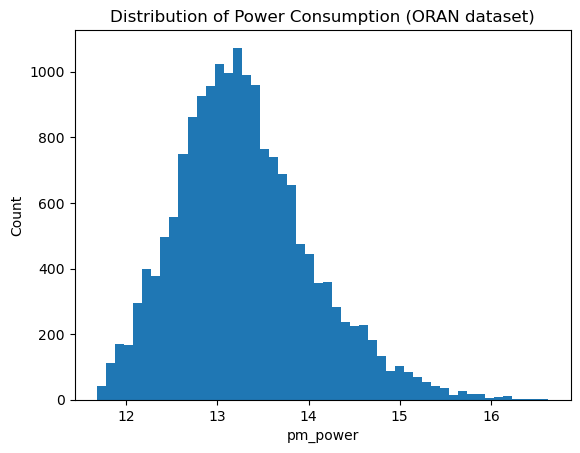

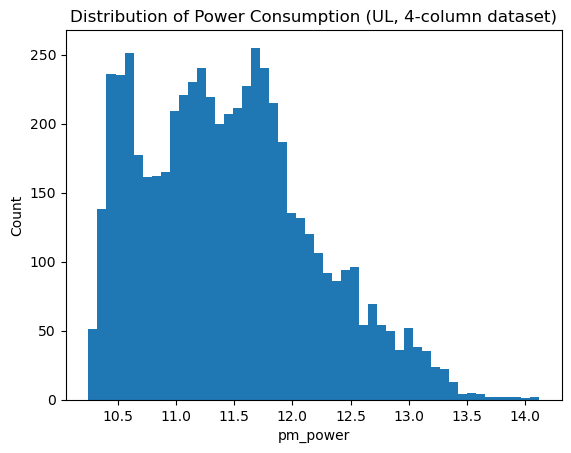

In [316]:

import matplotlib.pyplot as plt

plt.figure()
plt.hist(oran_4cols[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (ORAN dataset)")
plt.show()


plt.figure()
plt.hist(ul_4cols[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (UL, 4-column dataset)")
plt.show()





##  Visualisation: Power vs Airtime 

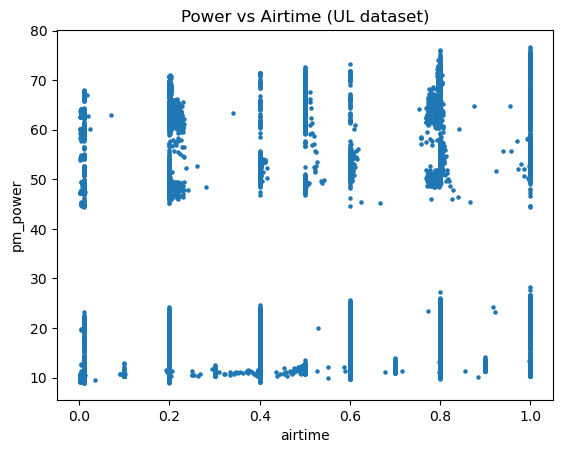

<function matplotlib.pyplot.show(close=None, block=None)>

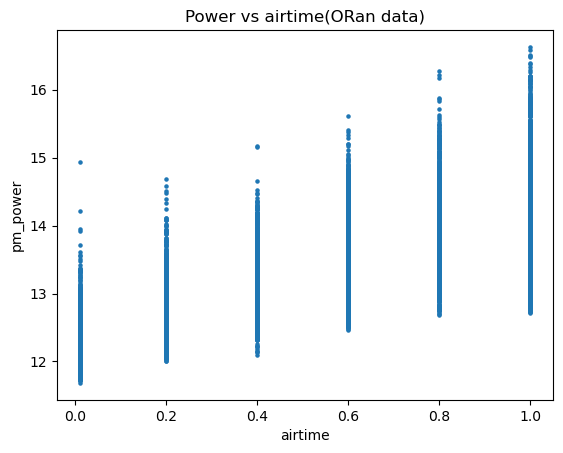

In [317]:
plt.figure()
plt.scatter(ul["airtime"], ul[TARGET], s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs Airtime (UL dataset)")
plt.show()

plt.figure()
plt.scatter(oran["airtime"],oran[TARGET],s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs airtime(ORan data)")
plt.show


##  Visualisation: Power vs Selected MCS 

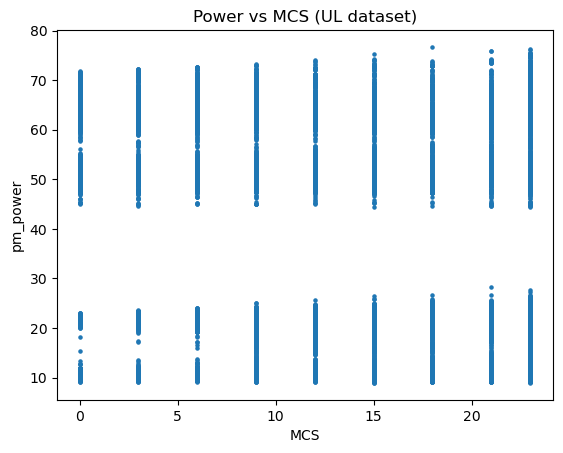

<function matplotlib.pyplot.show(close=None, block=None)>

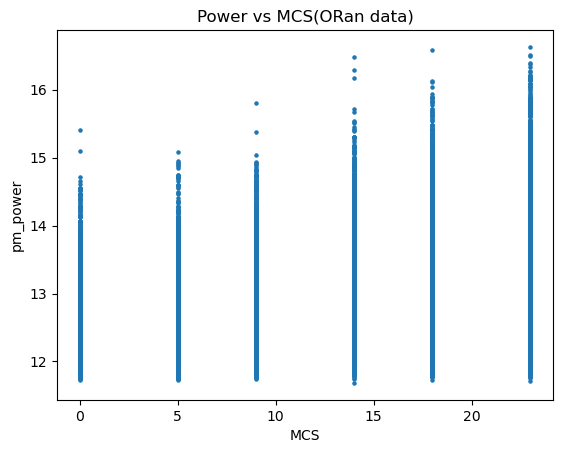

In [318]:
plt.figure()
plt.scatter(ul["selected_mcs"], ul[TARGET], s=5)
plt.xlabel("MCS")
plt.ylabel(TARGET)
plt.title("Power vs MCS (UL dataset)")
plt.show()

plt.figure()
plt.scatter(oran["selected_mcs"],oran[TARGET],s=5)
plt.xlabel("MCS")
plt.ylabel(TARGET)
plt.title("Power vs MCS(ORan data)")
plt.show

##  Visualisation: Power vs Txgain 

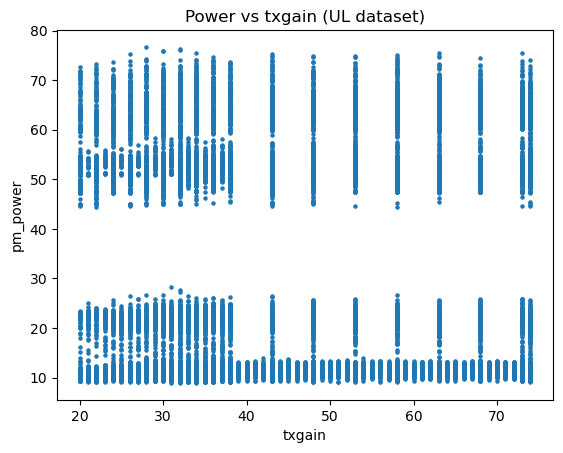

<function matplotlib.pyplot.show(close=None, block=None)>

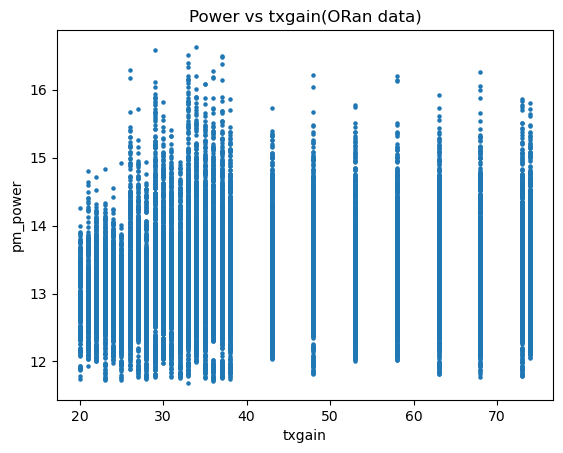

In [319]:
plt.figure()
plt.scatter(ul["txgain"], ul[TARGET], s=5)
plt.xlabel("txgain")
plt.ylabel(TARGET)
plt.title("Power vs txgain (UL dataset)")
plt.show()

plt.figure()
plt.scatter(oran["txgain"],oran[TARGET],s=5)
plt.xlabel("txgain")
plt.ylabel(TARGET)
plt.title("Power vs txgain(ORan data)")
plt.show

## Visualisation: ORAN vs UL power distribution comparison

Compare the target power distributions across ORAN and UL datasets.
If the distributions differ, this indicates a dataset shift between data sources.

A clear distribution shift motivates transfer learning:
- The task is the same (predict power)
- Feature semantics are aligned
- But the data distributions differ across domains


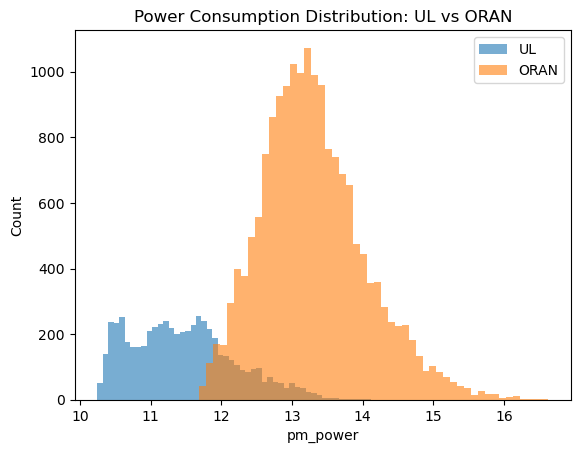

In [320]:
plt.figure()
plt.hist(ul_4cols[TARGET], bins=50, alpha=0.6, label="UL")
plt.hist(oran_4cols[TARGET], bins=50, alpha=0.6, label="ORAN")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Power Consumption Distribution: UL vs ORAN")
plt.legend()
plt.show()


## Summary 

In Stage 1, cleaned and aligned two independent datasets into a shared feature space consisting of a small set of common features and one power target variable. 

Basic visualisations show:
- The target power distribution in UL is multi-modal, suggesting different operating regimes.
- The relationship between airtime and power is not purely linear.
- ORAN and UL have different power distributions, indicating a distribution shift.

These observations motivate the use of machine learning and transfer learning in the next stages.

In [321]:
import pandas as pd

# Count the airtime coverage for each (selected_mcs, txgain)
airtime_stats = (
    ul_4cols
    .groupby(["selected_mcs", "txgain"])["airtime"]
    .agg(
        num_samples="count",
        num_airtime="nunique",
        min_airtime="min",
        max_airtime="max"
    )
    .reset_index()
)

# Define "qualified candidates" : airtime has sufficient coverage and a wide enough scope
airtime_candidates = airtime_stats[
    (airtime_stats["num_airtime"] >= 8) &     # At least 8 airtime slots
    (airtime_stats["min_airtime"] <= 0.1) &
    (airtime_stats["max_airtime"] >= 0.9)
].copy()

# Sort by "number of airtime slots + number of samples" and select the best one
airtime_candidates = airtime_candidates.sort_values(
    ["num_airtime", "num_samples"],
    ascending=[False, False]
)

print("=== Fig.1 best candidates (top 10) ===")
print(airtime_candidates.head(10))


best_mcs   = airtime_candidates.iloc[0]["selected_mcs"]
best_gain  = airtime_candidates.iloc[0]["txgain"]

print(f"✅ Best Fig.1 fixed condition: selected_mcs={best_mcs}, txgain={best_gain}")


=== Fig.1 best candidates (top 10) ===
     selected_mcs  txgain  num_samples  num_airtime  min_airtime  max_airtime
443            23      32           22           17         0.01          1.0
444            23      33           22           17         0.01          1.0
445            23      34           22           17         0.01          1.0
446            23      35           22           17         0.01          1.0
447            23      36           22           17         0.01          1.0
448            23      37           22           17         0.01          1.0
449            23      38           22           17         0.01          1.0
450            23      39           22           17         0.01          1.0
451            23      40           22           17         0.01          1.0
452            23      41           22           17         0.01          1.0
✅ Best Fig.1 fixed condition: selected_mcs=23.0, txgain=32.0


In [322]:
txgain_stats = (
    ul_4cols
    .groupby(["airtime", "selected_mcs"])["txgain"]
    .agg(
        num_samples="count",
        num_txgain="nunique"
    )
    .reset_index()
)

txgain_candidates = txgain_stats[txgain_stats["num_txgain"] >= 3] \
    .sort_values(["num_txgain", "num_samples"], ascending=[False, False])

print("\n=== Fig.2 best candidates (top 10) ===")
print(txgain_candidates.head(10))

best_mcs   = txgain_candidates.iloc[0]["selected_mcs"]
best_airtime  = txgain_candidates.iloc[0]["airtime"]

print(f"✅ Best Fig.2 fixed condition: selected_mcs={best_mcs}, airtime={best_airtime}")



=== Fig.2 best candidates (top 10) ===
     airtime  selected_mcs  num_samples  num_txgain
49      0.30            23          109          55
16      0.01            23          103          55
81      0.50            23          100          55
122     0.90            23           98          55
132     1.00            23           98          55
8       0.01             0           55          55
9       0.01             3           55          55
10      0.01             6           55          55
11      0.01             9           55          55
19      0.10            23           55          55
✅ Best Fig.2 fixed condition: selected_mcs=23.0, airtime=0.3


In [323]:
mcs_stats = (
    ul_4cols
    .groupby(["airtime", "txgain"])["selected_mcs"]
    .agg(
        num_samples="count",
        num_mcs="nunique"
    )
    .reset_index()
)

mcs_candidates = mcs_stats[mcs_stats["num_mcs"] >= 3] \
    .sort_values(["num_mcs", "num_samples"], ascending=[False, False])

print("\n=== Fig.3 best candidates (top 10) ===")
print(mcs_candidates.head(10))

best_gain  = mcs_candidates.iloc[0]["txgain"]
best_airtime  = mcs_candidates.iloc[0]["airtime"]

print(f"✅ Best Fig.3 fixed condition: airtime={best_airtime}, txgain={best_gain}")



=== Fig.3 best candidates (top 10) ===
     airtime  txgain  num_samples  num_mcs
295     0.30      27           13        9
293     0.30      25           12        9
294     0.30      26           12        9
297     0.30      29           11        9
474     0.50      28           11        9
477     0.50      31           11        9
16      0.01      27           10        9
18      0.01      29           10        9
19      0.01      30           10        9
20      0.01      31           10        9
✅ Best Fig.3 fixed condition: airtime=0.3, txgain=27.0


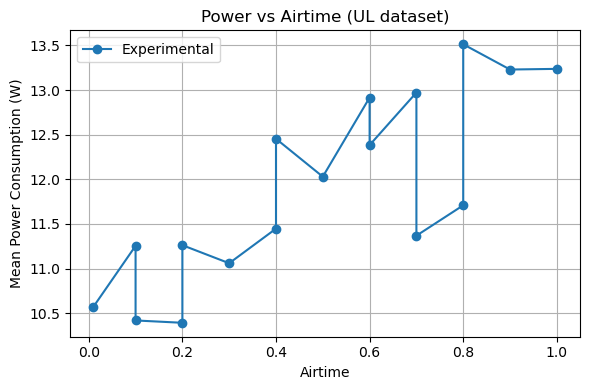

In [324]:
selected_mcs = 23
txgain = 32

df_f5 = ul_4cols[
    (ul_4cols["selected_mcs"] == 23) &
    (ul_4cols["txgain"] == 32)
]

df_plot = df_f5.groupby("airtime")["pm_power"].mean().reset_index()

df_f5_mean = (
    df_f5
    .groupby("airtime")["pm_power"]
    .mean()
    .reset_index()
    .sort_values("airtime")
)



import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(
    df_f5_mean["airtime"],
    df_f5_mean["pm_power"],
    marker="o",
    linestyle="-",
    label="Experimental"
)

plt.xlabel("Airtime")
plt.ylabel("Mean Power Consumption (W)")
plt.title("Power vs Airtime (UL dataset)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





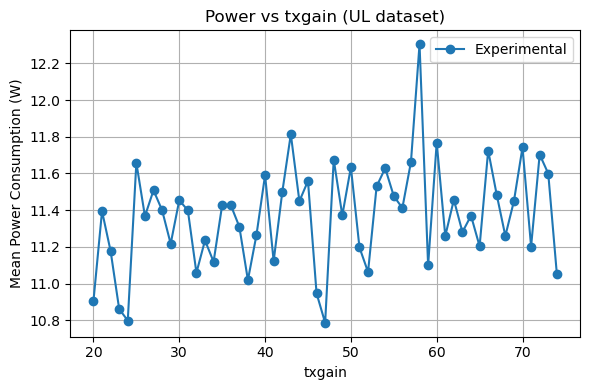

In [327]:
selected_mcs = 23
airtime = 0.3

df_f1 = ul_4cols[
    (ul_4cols["selected_mcs"] == 23) &
    (ul_4cols["airtime"] == 0.3)
]

df_plot = df_f1.groupby("txgain")["pm_power"].mean().reset_index()

df_f1_mean = (
    df_f1
    .groupby("txgain")["pm_power"]
    .mean()
    .reset_index()
    .sort_values("txgain")
)



import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(
    df_f1_mean["txgain"],
    df_f1_mean["pm_power"],
    marker="o",
    linestyle="-",
    label="Experimental"
)

plt.xlabel("txgain")
plt.ylabel("Mean Power Consumption (W)")
plt.title("Power vs txgain (UL dataset)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





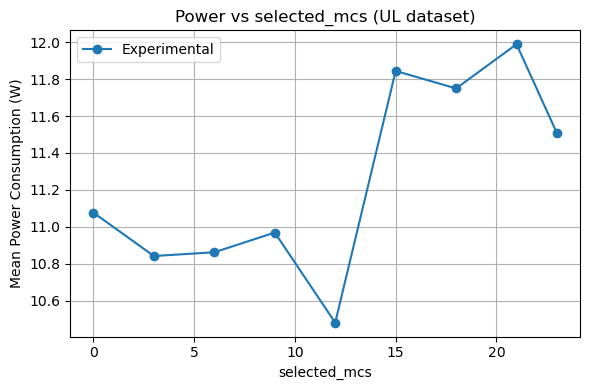

In [328]:
airtime = 0.3
txgain = 27

df_f4 = ul_4cols[
    (ul_4cols["airtime"] == 0.3) &
    (ul_4cols["txgain"] == 27)
]

df_plot = df_f4.groupby("selected_mcs")["pm_power"].mean().reset_index()

df_f4_mean = (
    df_f4
    .groupby("selected_mcs")["pm_power"]
    .mean()
    .reset_index()
    .sort_values("selected_mcs")
)



import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(
    df_f4_mean["selected_mcs"],
    df_f4_mean["pm_power"],
    marker="o",
    linestyle="-",
    label="Experimental"
)

plt.xlabel("selected_mcs")
plt.ylabel("Mean Power Consumption (W)")
plt.title("Power vs selected_mcs (UL dataset)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



